# Experiment: BBSS + RSI: Doesn't work


/workspace/nifty/NIFTY/201*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2020*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2021*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2022*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/20230*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/20231*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

/workspace/nifty/NIFTY/2024*.csv:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: xlabel='timeperiod'>

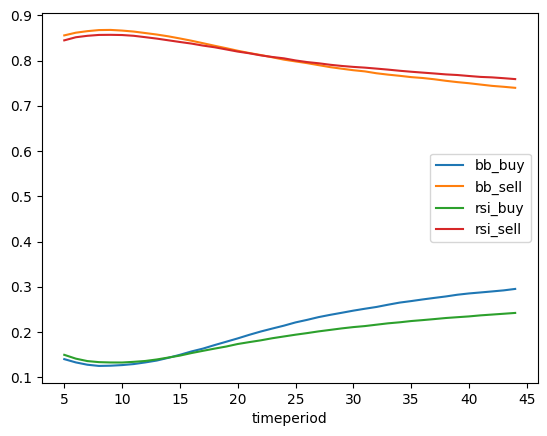

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import talib
from tqdm.notebook import trange, tqdm

# from option_history import get_nifty, get_option_chain
import backtesting as bt

import warnings
warnings.filterwarnings('ignore')


def load(file_):
    try:
        _df = pd.read_csv(file_, parse_dates=True)
        _df.datetime = pd.to_datetime(_df.datetime)
        _df['date'] = _df.datetime.dt.date
        _df.set_index('datetime', inplace=True)
        return _df
    except Exception as e:
        return pd.DataFrame()


def find_threshold(df, timeperiod: int = 14):
    groups = []
    for _, group in df.groupby('date'):
        group['rsi'] = talib.RSI(group.close, timeperiod=14)
        group['scaled_rsi'], _, _ = scale_by_bb(
            group.rsi,
            timeperiod=timeperiod
        )
        group['scaled_close'], _, _ = scale_by_bb(
            group.close,
            timeperiod=timeperiod
        )
        groups.append(group)

    df = pd.concat(groups)
    poi_bb_buy = (df['scaled_close'] * df.buy)
    poi_bb_sell = (df['scaled_close'] * df.sell)
    poi_rsi_buy = (df['scaled_rsi'] * df.buy)
    poi_rsi_sell = (df['scaled_rsi'] * df.sell)

    buy_q75 = poi_bb_buy.dropna().quantile(0.5)
    sell_q25 = poi_bb_sell.dropna().quantile(0.5)
    buy_rsi_q75 = poi_rsi_buy.dropna().quantile(0.5)
    sell_rsi_q25 = poi_rsi_sell.dropna().quantile(0.5)
    return (buy_q75, sell_q25), (buy_rsi_q75, sell_rsi_q25)


def scale_by_bb(
        series: pd.Series,
        deviation: int = 2,
        timeperiod: int = 20
):
    upper, _, lower = talib.BBANDS(
        series,
        timeperiod=timeperiod,
        nbdevup=deviation,
        nbdevdn=deviation
    )
    return (series - lower) / (upper - lower), upper, lower


def mark_events(data, ref_frame=5):
    data = data.copy()
    data['sell'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).max()).astype(int).replace(0, None)
    data['buy'] = (
        data['close'] == data['close'].shift(-ref_frame).rolling(2 * ref_frame).min()).astype(int).replace(0, None)
    data['hold'] = data.apply(lambda row: int(
        not (row['sell'] or row['buy'])), axis=1)
    return data


def load_historical_data(path_pattern, ref_frame=5):

    file_df = pd.DataFrame(
        [
            {
                'stock_code': file_.split('/')[-2],
                'path': file_,
            } for file_ in glob(path_pattern)
        ]
    )
    if file_df.empty:
        return pd.DataFrame()

    df_map = {}

    for stock, group in tqdm(file_df.groupby('stock_code'), desc=path_pattern):
        df_map[stock] = pd.concat(
            list(
                map(
                    load,
                    sorted(group.path.tolist())
                )
            )
        ).sort_index()

    nifty_df = df_map[stock]

    if 'only_date' in nifty_df.columns:
        nifty_df.drop(columns=['only_date'], inplace=True)

    groups = []

    for _, group in nifty_df.groupby(nifty_df.index.date):

        groups.append(
            mark_events(
                group,  # [['open', 'high', 'low', 'close']],
                ref_frame=ref_frame
            )
        )

    return pd.concat(groups)

# def load_historical_data(path_pattern):

#     file_df = pd.DataFrame([
#         {
#             'stock_code': file_.split('/')[-2],
#             'path': file_,
#         } for file_ in glob(path_pattern)
#         if 'options_history' not in file_ and 'OPTIONS' not in file_ and 'CALL' not in file_ and 'PUT' not in file_
#     ])

#     df_map = {}

#     for stock, group in tqdm(file_df.groupby('stock_code')):
#         df_map[stock] = pd.concat(
#             list(
#                 map(
#                     load,
#                     sorted(group.path.tolist())
#                 )
#             )
#         ).sort_index()

#     nifty_df = df_map[stock]
#     nifty_df = nifty_df.sort_index().drop(
#         columns=['exchange_code', 'stock_code', 'volume'])

#     if 'only_date' in nifty_df.columns:
#         nifty_df.drop(columns=['only_date'], inplace=True)

#     groups = []

#     for _, group in nifty_df.groupby('date'):
#         group = mark_events(group, ref_frame=5)
#         groups.append(group)

#     return pd.concat(groups)


training_data = pd.concat(
    [
        load_historical_data(
            '/workspace/nifty/NIFTY/201*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2020*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2021*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2022*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/20230*.csv'
        )
    ]
)

test_data = pd.concat(
    [
        load_historical_data(
            '/workspace/nifty/NIFTY/20231*.csv'
        ), load_historical_data(
            '/workspace/nifty/NIFTY/2024*.csv'
        )
    ]
)

records = []
for i in trange(5, 45):
    bb_thresholds, rsi_thresholds = find_threshold(training_data, timeperiod=i)
    records.append({
        'timeperiod': i,
        'bb_buy': bb_thresholds[0],
        'bb_sell': bb_thresholds[1],
        'rsi_buy': rsi_thresholds[0],
        'rsi_sell': rsi_thresholds[1],
    })
thresholds_df = pd.DataFrame(records)
thresholds_df.set_index('timeperiod').plot()

In [2]:

file_df = pd.DataFrame([
    {
        'stock_code': file_.split('/')[-2],
        'path': file_,
    } for file_ in (
        glob('/workspace/nifty/NIFTY/202312*.csv') +
        # glob('/workspace/nifty/NIFTY/2024*.csv') +
        []
    )
    if 'options_history' not in file_ and 'OPTIONS' not in file_ and 'CALL' not in file_ and 'PUT' not in file_
])

df_map = {}

for stock, group in tqdm(file_df.groupby('stock_code')):
    df_map[stock] = pd.concat(
        list(
            map(
                load,
                sorted(group.path.tolist())
            )
        )
    ).sort_index()

opt_df = df_map[stock]
opt_df = opt_df.sort_index().drop(
    columns=['exchange_code', 'stock_code', 'volume'])

opt_df.tail()

  0%|          | 0/1 [00:00<?, ?it/s]

,close,high,low,open,date
datetime,,,,,
2023-12-29 15:25:00,21727.25,21729.15,21722.50,21723.35,2023-12-29
2023-12-29 15:26:00,21730.90,21731.45,21725.10,21726.00,2023-12-29
2023-12-29 15:27:00,21736.30,21738.40,21729.35,21731.20,2023-12-29
2023-12-29 15:28:00,21734.65,21739.35,21729.65,21736.40,2023-12-29
2023-12-29 15:29:00,21728.30,21735.65,21724.70,21734.10,2023-12-29


Start                     2023-12-01 09:09:00
End                       2023-12-29 15:29:00
Duration                     28 days 06:20:00
Exposure Time [%]                   42.772668
Equity Final [$]                      30002.6
Equity Peak [$]                       30076.3
Return [%]                           0.008667
Buy & Hold Return [%]                7.597269
Return (Ann.) [%]                   -1.062668
Volatility (Ann.) [%]                2.467136
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -0.92149
Avg. Drawdown [%]                   -0.107139
Max. Drawdown Duration       17 days 04:44:00
Avg. Drawdown Duration        1 days 10:38:00
# Trades                                  406
Win Rate [%]                        37.192118
Best Trade [%]                       0.175935
Worst Trade [%]                     -0.082293
Avg. Trade [%]                    

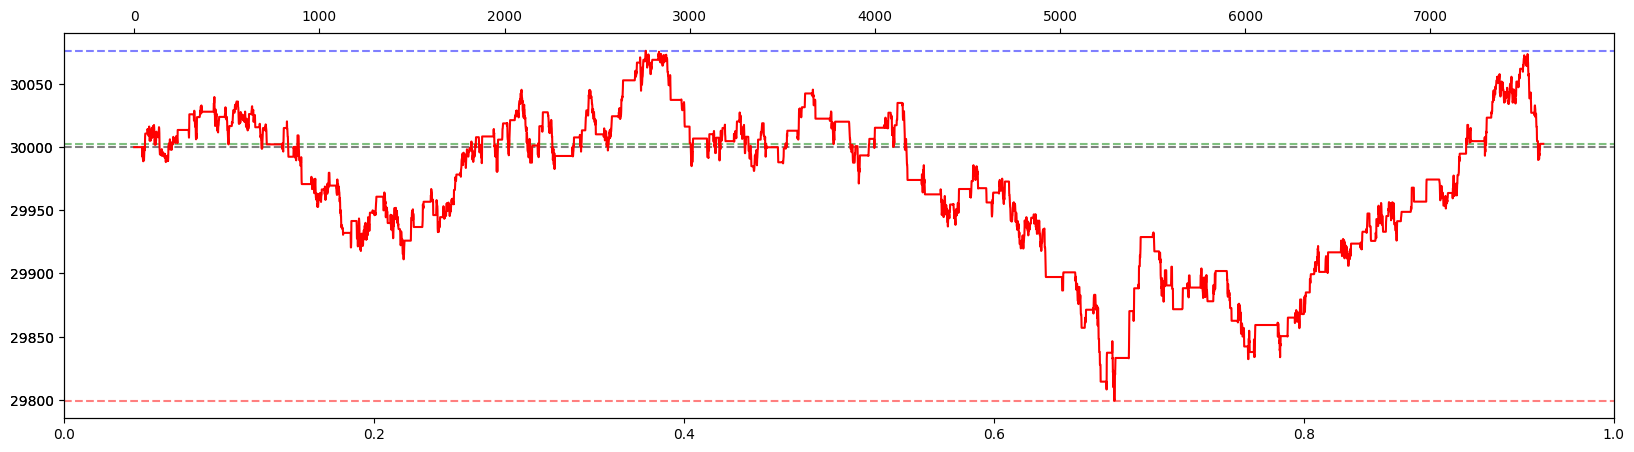

In [3]:
import numpy as np


def reversal(series, threshold, inv=False):
    op = np.less_equal if inv else np.greater_equal
    rop = np.greater_equal if inv else np.less_equal

    filters = op(series, threshold)
    filters &= op(series.shift(1), threshold)
    filters &= op(series.shift(2), threshold)
    filters &= rop(series.shift(1), series.shift(2))
    filters &= rop(series.shift(1), series)
    return filters.iloc[-1]


class BBStrategy(bt.Strategy):
    signal = None
    SL = 10
    TP = 10
    TIMEPERIOD = 25

    def _is_trading_window(self):
        if (
            self.data.index[-1].hour == 15 and
            self.data.index[-1].minute > 15
        ) or (
            self.data.index[-1].hour == 9 and
            self.data.index[-1].minute < 30
        ):
            return False
        return True

    def init(self):
        self._open = self.data.Open
        self._high = self.data.High
        self._low = self.data.Low
        self._close = self.data.Close
        self._rsi = talib.RSI(self.data.Close, timeperiod=self.TIMEPERIOD)/100

        self._scaled_close, _, _ = scale_by_bb(
            self.data.Close,
            timeperiod=self.TIMEPERIOD
        )
        self._scaled_rsi, _, _ = scale_by_bb(
            self._rsi,
            timeperiod=self.TIMEPERIOD
        )
        self._scaled_close = self.I(
            lambda x: x,
            self._scaled_close,
            name='scaled_close'
        )
        try:
            (
                _,
                self._buy_bb,
                self._sell_bb,
                self._buy_rsi,
                self._sell_rsi
            ) = thresholds_df[thresholds_df.timeperiod == self.TIMEPERIOD].values[0]

        except Exception as e:
            print(e, self.TIMEPERIOD)
            raise e

    def next(self):
        if not self._is_trading_window():
            self.position.close()
            return

        if (
            reversal(pd.Series(self._scaled_close), self._sell_bb, inv=False)
            # bt.lib.crossover(self._scaled_close, self._sell_bb)
            # and bt.lib.crossover(self._scaled_rsi, self._sell_rsi)
        ):
            self.position.close()
            self.sell(
                size=1,
                sl=self.data.High + self.SL,
                tp=self.data.Low - self.TP,
            )

        if (
            reversal(pd.Series(self._scaled_close), self._buy_bb, inv=True)
            # bt.lib.crossover(self._buy_bb, self._scaled_close)
            # and bt.lib.crossover(self._buy_rsi, self._scaled_rsi)
        ):
            self.position.close()
            self.buy(
                size=1,
                sl=self.data.Low - self.SL,
                tp=self.data.High + self.TP,
            )


test = bt.Backtest(
    opt_df.rename(
        {
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
        },
        axis=1
    ),
    BBStrategy,
    cash=30000,
    commission=.0000,
    exclusive_orders=True,
    trade_on_close=True,
)

stats = test.run()
fig, ax = plt.subplots(figsize=(20, 5))
stats._equity_curve['date'] = stats._equity_curve.index.date
ax.axhline(stats._equity_curve.Equity.max(), color='b', ls='--', alpha=0.5)
ax.axhline(stats._equity_curve.Equity.min(), color='r', ls='--', alpha=0.5)
ax.axhline(stats._equity_curve.Equity.iloc[-1], color='g', ls='--', alpha=0.5)
ax.axhline(30000, color='k', ls='--', alpha=0.5)

stats._equity_curve.reset_index().Equity.plot(ax=ax.twiny(), color='r')

print(stats)

In [ ]:


def profit_quantile(ser: pd.Series) -> float:
    return (np.nan_to_num(ser._trades.PnL.quantile(.5), -9999999))
    # return (np.nan_to_num(ser._trades.PnL.quantile(.25), -9999999) * ser['# Trades']).sum()


opt = test.optimize(
    TIMEPERIOD=range(5, 45),
    SL=range(2, 20, ),
    TP=range(2, 30, ),
    # maximize='Equity Final [$]',
    maximize=profit_quantile,
)
opt

In [ ]:
(opt._trades.PnL.quantile([.05, .25, .5, .75, .95]))

0.05   -20.4725
0.25   -18.5500
0.50    12.1500
0.75    15.0625
0.95    18.8450
Name: PnL, dtype: float64

In [ ]:
{
    'metric': 'optimize_on',
    'SL': opt._strategy.SL,
    'TP': opt._strategy.TP,
    'TIMEPERIOD': opt._strategy.TIMEPERIOD,
    'SQN': opt['SQN'],
    'Equity Final [$]': opt['Equity Final [$]'],
    'Win Rate [%]': opt['Win Rate [%]'],
    'Avg. Trade [%]': opt['Avg. Trade [%]'],
    'Sharpe Ratio': opt['Sharpe Ratio'],
    '# Trades': opt['# Trades'],
    'Expectancy [%]': opt['Expectancy [%]'],
    'Return [%]': opt['Return [%]'],
    'Trades Per Day': (opt['# Trades']/max(1, opt['Duration'].days)),
    'Expected Final': (opt['Equity Final [$]'] - 30000) * .8 * 50 * 5 - 35 * opt['# Trades'],
}

{'metric': 'optimize_on',
 'SL': 18,
 'TP': 8,
 'TIMEPERIOD': 5,
 'SQN': 0.36322125464379296,
 'Equity Final [$]': 30033.499999999996,
 'Win Rate [%]': 57.14285714285714,
 'Avg. Trade [%]': 0.005530593427049979,
 'Sharpe Ratio': 1.038224895689797,
 '# Trades': 28,
 'Expectancy [%]': 0.005563605952891134,
 'Return [%]': 0.11166666666665453,
 'Trades Per Day': 1.0,
 'Expected Final': 5719.999999999272}

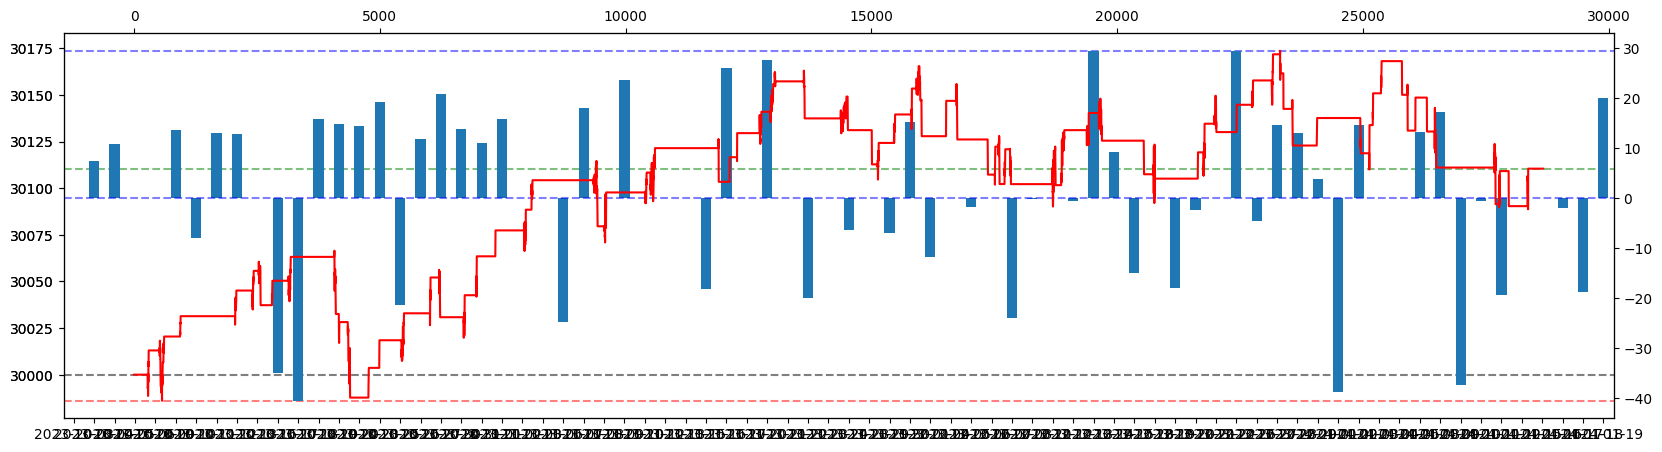

Start                     2023-10-03 09:09:00
End                       2024-01-19 15:29:00
Duration                    108 days 06:20:00
Exposure Time [%]                    6.087563
Equity Final [$]                     30110.45
Equity Peak [$]                      30173.65
Return [%]                           0.368167
Buy & Hold Return [%]               10.272953
Return (Ann.) [%]                    1.080666
Volatility (Ann.) [%]                0.839375
Sharpe Ratio                         1.287464
Sortino Ratio                        1.803312
Calmar Ratio                         3.836192
Max. Drawdown [%]                   -0.281703
Avg. Drawdown [%]                   -0.042726
Max. Drawdown Duration       27 days 23:27:00
Avg. Drawdown Duration        1 days 15:30:00
# Trades                                   87
Win Rate [%]                         58.62069
Best Trade [%]                       0.139554
Worst Trade [%]                     -0.112843
Avg. Trade [%]                    

0.05   -19.990
0.25   -18.450
0.50    11.500
0.75    14.775
0.95    18.860
Name: PnL, dtype: float64

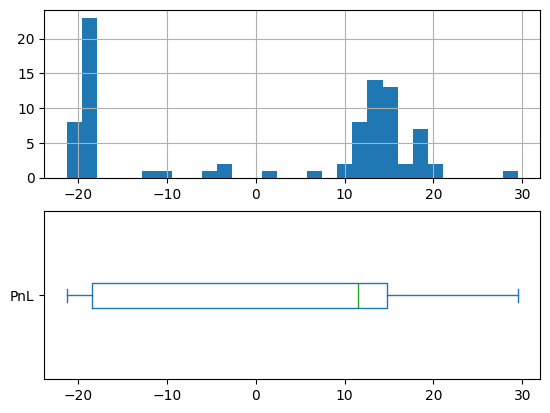

In [ ]:
#  'SL': 31,
#  'TP': 2,
#  'TIMEPERIOD': 29,

OptStrat = BBStrategy
OptStrat.TP = opt._strategy.TP
OptStrat.SL = opt._strategy.SL
OptStrat.TIMEPERIOD = opt._strategy.TIMEPERIOD
# OptStrat.TP = 40
# OptStrat.SL = 43
# OptStrat.TIMEPERIOD = 36

# file_df = pd.DataFrame([
#     {
#         'stock_code': file_.split('/')[-2],
#         'path': file_,
#     } for file_ in (
#         # glob('/workspace/nifty/NIFTY/2023*.csv') +
#         glob('/workspace/nifty/NIFTY/2024*.csv')
#     )
#     if 'options_history' not in file_ and 'OPTIONS' not in file_ and 'CALL' not in file_ and 'PUT' not in file_
# ])

# df_map = {}

# for stock, group in tqdm(file_df.groupby('stock_code')):
#     df_map[stock] = pd.concat(
#         list(
#             map(
#                 load,
#                 sorted(group.path.tolist())
#             )
#         )
#     ).sort_index()

# nifty_df = df_map[stock]
# nifty_df = nifty_df.sort_index().drop(
#     columns=['exchange_code', 'stock_code', 'volume'])


test = bt.Backtest(
    test_data.rename(
        {
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
        },
        axis=1
    ),
    OptStrat,
    cash=30000,
    commission=.0000,
    exclusive_orders=True,
    trade_on_close=True,
)

stats = test.run()
fig, ax = plt.subplots(figsize=(20, 5))
stats._equity_curve['date'] = stats._equity_curve.index.date
ax.axhline(stats._equity_curve.Equity.max(), color='b', ls='--', alpha=0.5)
ax.axhline(stats._equity_curve.Equity.min(), color='r', ls='--', alpha=0.5)
ax.axhline(stats._equity_curve.Equity.iloc[-1], color='g', ls='--', alpha=0.5)
ax.axhline(30000, color='k', ls='--', alpha=0.5)

xax = ax.twinx()
(stats._equity_curve.groupby('date').Equity.last().diff()).plot.bar(ax=xax)

# # .plot(ax=ax)
yax = ax.twiny()
stats._equity_curve.reset_index().Equity.plot(ax=yax, color='r')
xax.axhline(0, color='b', ls='--', alpha=0.5)

plt.show()

fig, ax = plt.subplots(2, 1, )

stats._trades.PnL.hist(bins=30, ax=ax[0])
stats._trades.PnL.plot.box(ax=ax[1], vert=False)

# quantile([.05, .25, .5, .75, .95])
print(stats)
stats._trades.PnL.quantile([.05, .25, .5, .75, .95])

wl
Loss    Axes(0.125,0.11;0.775x0.77)
Win     Axes(0.125,0.11;0.775x0.77)
Name: PnL, dtype: object

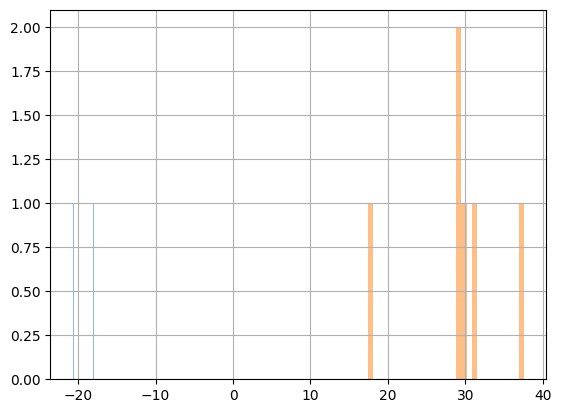

In [ ]:
opt._trades['wl'] = np.sign(opt._trades.PnL).replace({1: 'Win', -1: 'Loss'})
opt._trades.groupby('wl').PnL.hist(bins=30, alpha=0.5)

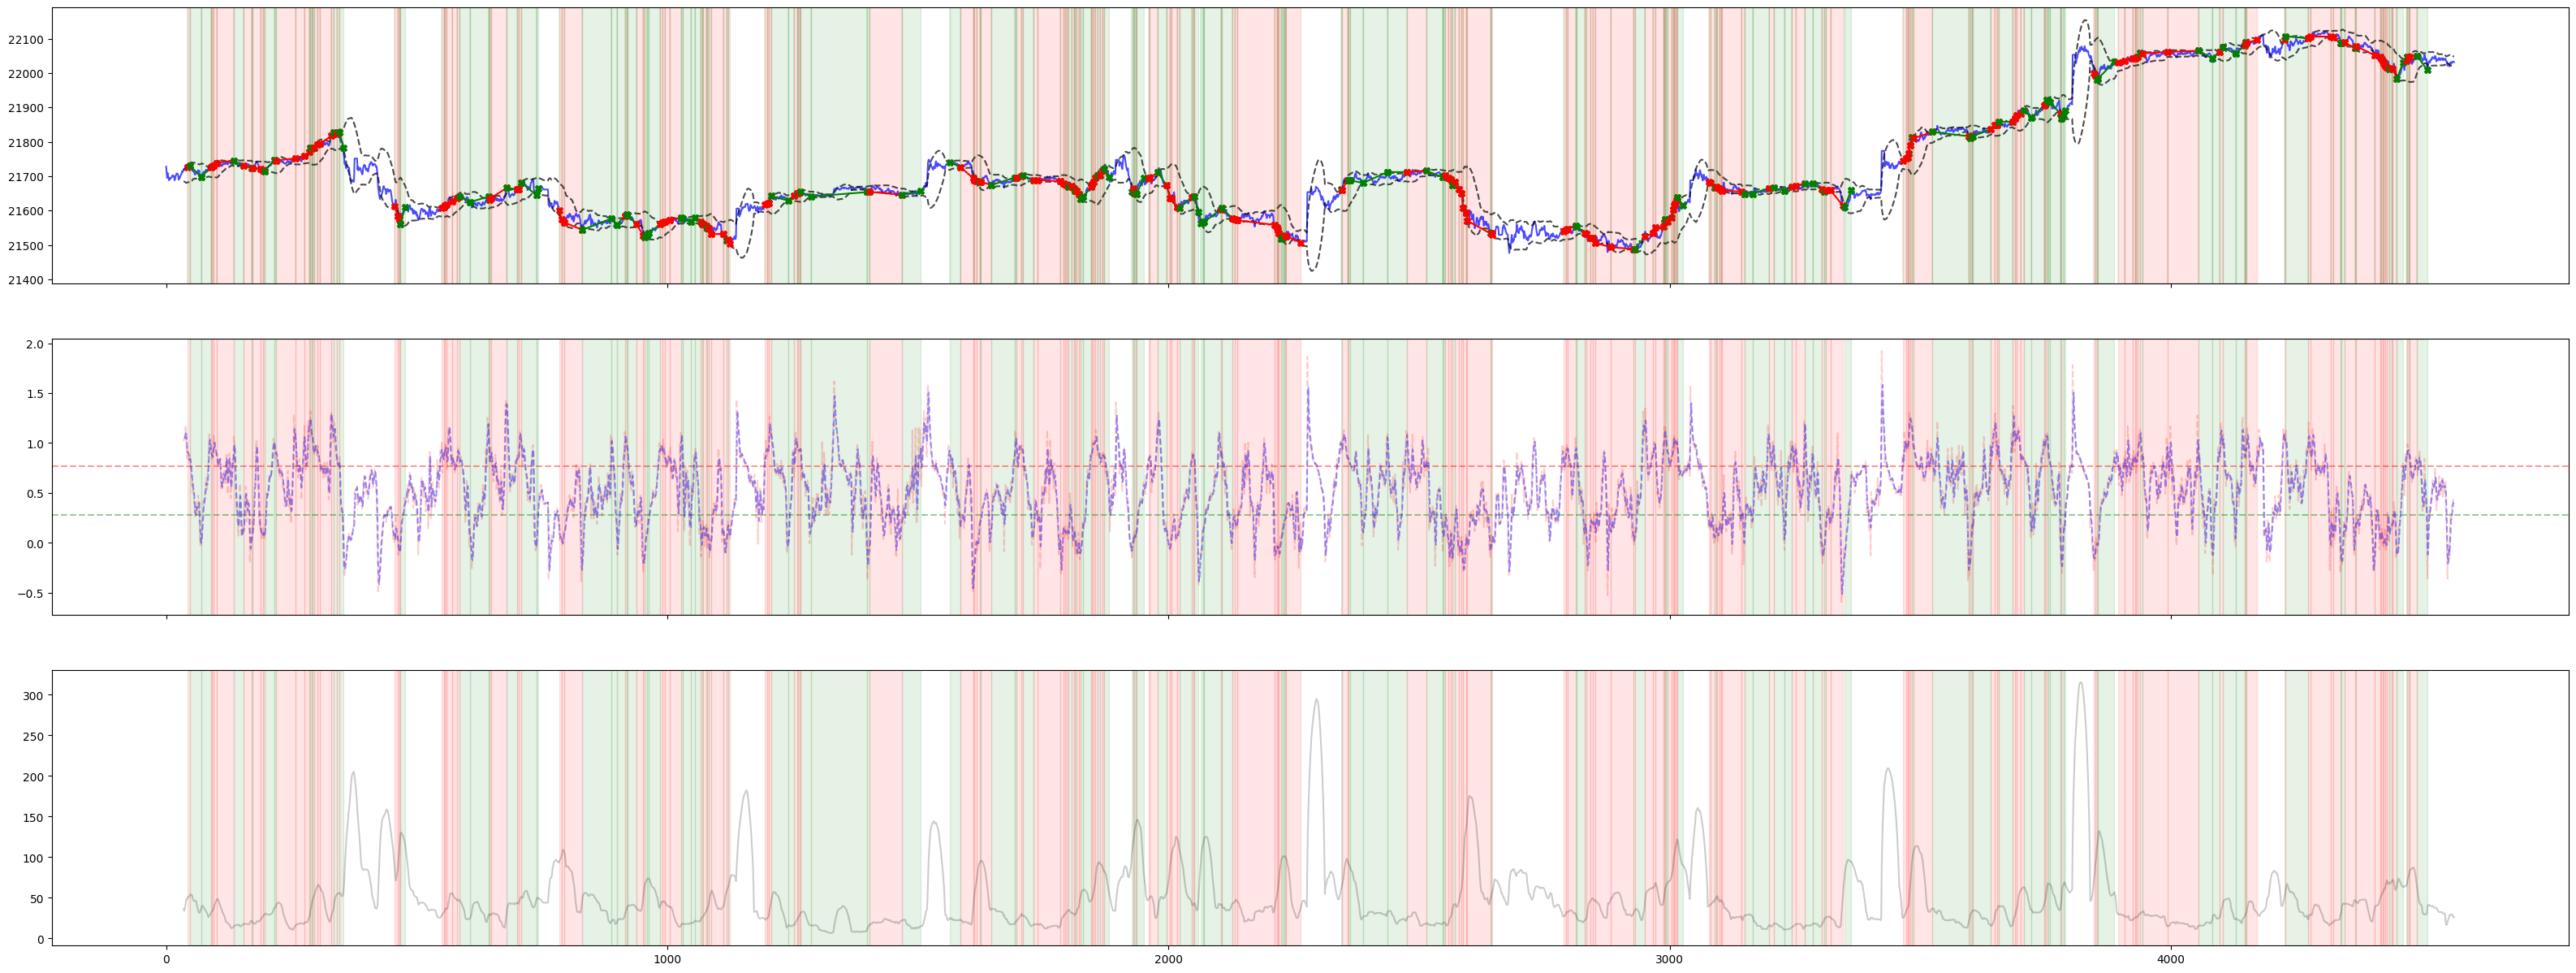

In [ ]:
# nifty_df.reset_index(inplace=True)
nifty_df.reset_index(inplace=True)

fig, (ax, iax, wax) = plt.subplots(3, 1, figsize=(40, 15), sharex=True)
(
    _,
    buy_bb,
    sell_bb,
    _,
    _
) = thresholds_df[thresholds_df.timeperiod == OptStrat.TIMEPERIOD].values[0]
trades_df = stats._trades

scaled_close, ub, lb = scale_by_bb(
    nifty_df.close,
    timeperiod=OptStrat.TIMEPERIOD
)

width = (ub-lb)

wax.plot(width.index, width, color='k', alpha=.2)

# tax = ax.twinx()
ax.plot(nifty_df.close, alpha=.7, color='blue')
ax.plot(ub, alpha=.7, ls='--', color='k')
ax.plot(lb, alpha=.7, ls='--', color='k')

for trade in trades_df.to_dict('records'):
    ax.plot(
        [trade['EntryBar'], trade['ExitBar']],
        [trade['EntryPrice'], trade['ExitPrice']],
        c=('g' if trade['PnL'] >= 0 else 'r'),
        marker='X'
    )

    # iax.scatter(
    #     trade['EntryBar'],
    #     trade['scaled_close'],
    #     c=('g' if trade['PnL'] >= 0 else 'r'),
    #     marker='X'
    # )

    ax.axvline(trade['EntryBar'], c='g', alpha=.1)

    ax.axvspan(
        trade['EntryBar'],
        trade['ExitBar'],
        color=('g' if trade['PnL'] >= 0 else 'r'),
        alpha=.1
    )

    iax.axvspan(
        trade['EntryBar'],
        trade['ExitBar'],
        color=('g' if trade['PnL'] >= 0 else 'r'),
        alpha=.1
    )
    wax.axvspan(
        trade['EntryBar'],
        trade['ExitBar'],
        color=('g' if trade['PnL'] >= 0 else 'r'),
        alpha=.1
    )

iax.axhline(sell_bb, color='r', alpha=.4, ls='--')
iax.axhline(buy_bb, color='g', alpha=.4, ls='--')
iax.plot(scaled_close, color='r', alpha=.2, ls='--')
iax.plot(scaled_close.rolling(3).mean(), color='b', alpha=.4, ls='--')
plt.show()

In [ ]:
nifty_df['scaled_close'], nifty_df['ub'], nifty_df['lb'] = scale_by_bb(
    nifty_df.close,
    timeperiod=OptStrat.TIMEPERIOD

)
ndf = nifty_df.merge(
    trades_df[['EntryBar', 'EntryPrice', 'EntryTime', 'PnL']],
    left_on='index',
    right_on='EntryBar',
    how='left',
).merge(
    trades_df[['ExitBar', 'ExitPrice', 'ExitTime', 'PnL']],
    left_on='index',
    right_on='ExitBar',
    how='left'
)
ndf

KeyError: 'index'

In [ ]:
import numpy as np
entry_df = ndf[['scaled_close', 'ub', 'lb', 'PnL_x']].dropna()

entry_df['win'] = np.sign(entry_df['PnL_x'])
entry_df['width'] = entry_df['ub'] - entry_df['lb']
for w, g in entry_df.groupby('win'):

    g['scaled_close'].plot.box(layout=(2, 1))
    plt.show()

# .quantile([.05, .25, .5, .75, .95]).reset_index().pivot(
#     index='win', columns='level_1', values='scaled_close'
# )